# 位置显著性分析主程序

本notebook用于分析RNAscope数据中基因表达的位置分布显著性，包括：
1. 数据加载和预处理
2. 位置分布区间创建
3. 蒙特卡洛模拟分析
4. 多重比较校正
5. 结果可视化和保存

**注意**: 本程序专门处理位置分布显著性分析

In [1]:
# 导入必要的库
import os
from numba import njit, prange
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from modules.judge_sig import (
    create_position_bins,
    two_step_stratified_sample,
    count_positive_in_bins,  # 假设这个函数存在于judge_sig模块中
    correct_grid_pvalues,
    count_positive_in_x_bins
)

print('✅ 模块导入完成！')

✅ 模块导入完成！


In [2]:
# 分析参数
n_simulations = 10000
num_xbins = 20
num_ybins = 10
correction_method = 'fdr'
bx_min = -0.6
bx_max = 0.6
by_min = -0.6
by_max = 0.6

cell_num = 0
random_num = 42

# 要比较的样品类型
sample_types = ['tmie', 'wt']

# ----------------------
# 设置路径和参数
# ----------------------
base_folder = 'D:/Ruiqi/vg_space_mapping/wt/'
summary_folder = os.path.join(base_folder, "summary")
sample_info_path = os.path.join(summary_folder, "sample_info.csv")
results_file_path = os.path.join(summary_folder, 'vg_averageing_labels.csv')
vg_size_path = os.path.join(summary_folder, 'vg_size.csv')

# 打印配置信息
print(f'根目录: {base_folder}')
print(f'汇总文件夹: {summary_folder}')
print(f'模拟次数: {n_simulations}')
print(f'x分箱数量: {num_xbins}, y分箱数量 ：{num_ybins}')
print(f'校正方法: {correction_method}')
print(f'比较的样品类型: {sample_types}')

根目录: D:/Ruiqi/vg_space_mapping/wt/
汇总文件夹: D:/Ruiqi/vg_space_mapping/wt/summary
模拟次数: 10000
x分箱数量: 20, y分箱数量 ：10
校正方法: fdr
比较的样品类型: ['tmie', 'wt']


In [3]:
# ----------------------
# 数据加载和预处理
# ----------------------
def load_data(sample_type):
    """加载指定样品类型的所有必要数据"""
    try:
        # 加载样品数据
        sample_data_path = os.path.join(summary_folder, sample_type + "_summary_all.csv")
        sample_data = pd.read_csv(sample_data_path)
        print(f"成功加载{sample_type}数据，共{len(sample_data)}行")
        
        # 加载BX/BY数据
        results_data = pd.read_csv(results_file_path, header=None)
        BX = results_data.iloc[:, 0].values
        BY = results_data.iloc[:, 1].values
        print(f"成功加载BX/BY数据，长度分别为: {len(BX)}, {len(BY)}")
        
        return sample_data, BX, BY
    except Exception as e:
        print(f"{sample_type}数据加载错误: {e}")
        raise

def preprocess_data(data, vg_size):
    """预处理数据：去重、计算标准化坐标等"""
    # 去重
    original_count = len(data)
    data = data.drop_duplicates(keep='first')
    deduplicated_count = len(data)
    removed_count = original_count - deduplicated_count
    print(f"去重后记录数: {deduplicated_count} (移除了{removed_count}条完全重复的记录)")
    
    # 计算标准化坐标
    avg_vg_size = vg_size.mean(axis=0).values
    print(f"vg大小平均值: {avg_vg_size}")
    
    # 查找坐标列
    x_col = next((col for col in data.columns if col.endswith('warpedROIvar1')), None)
    y_col = next((col for col in data.columns if col.endswith('warpedROIvar2')), None)
    
    if not x_col or not y_col:
        missing = []
        if not x_col: missing.append("warpedROIvar1结尾的列")
        if not y_col: missing.append("warpedROIvar2结尾的列")
        raise ValueError(f"缺少必要的坐标列: {', '.join(missing)}")
    
    print(f"找到坐标列: X={x_col}, Y={y_col}")
    
    # 计算标准化坐标
    data['standardized_x'] = data[x_col] / avg_vg_size[0]
    data['standardized_y'] = data[y_col] / avg_vg_size[1]
    
    # 提取阳性标记列
    is_positive_cols = [col for col in data.columns if col.endswith('_isPositive')]
    if not is_positive_cols:
        raise ValueError("未找到任何以'_isPositive'结尾的列，请检查数据列名")
    print(f"找到{len(is_positive_cols)}个阳性标记列")
    
    # 采样（如果需要）
    if cell_num > 0:
        data = two_step_stratified_sample(data, cell_num, random_num)
    
    return data, is_positive_cols, x_col, y_col

# 加载vg大小数据
vg_size = pd.read_csv(vg_size_path, header=None)

# 加载并预处理两种样品的数据
data1, BX, BY = load_data(sample_types[0])
data2, BX, BY = load_data(sample_types[1])
data1, positive_cols1, x_col, y_col = preprocess_data(data1, vg_size)
data2, positive_cols2, x_col, y_col = preprocess_data(data2, vg_size)

# 确保两种样品有相同的阳性标记列
common_markers = set(positive_cols1)
common_markers.intersection_update(positive_cols2)

common_markers = sorted(list(common_markers))
print(f"\n两种样品共有的标记列: {common_markers}")

# 计算BX和BY的边界（使用两种样品的合并范围）
all_BX = BX
all_BY = BY

order_list=[0, 7, 2, 6, 4, 5, 3, 1, 0]
BX_ordered = BX[order_list]
BY_ordered = BY[order_list]
cs = CubicSpline(np.arange(len(BX_ordered)), np.c_[BX_ordered, BY_ordered], 
                axis=0, bc_type='periodic')
t_fine = np.linspace(0, len(BX_ordered)-1, 300)
x_fine, y_fine = cs(t_fine).T

actual_bx_min, actual_bx_max = x_fine.min(), x_fine.max()
actual_by_min, actual_by_max = y_fine.min(), y_fine.max()

# 创建区间
bx_bins, by_bins = create_position_bins(
    actual_bx_min, actual_bx_max,
    actual_by_min, actual_by_max,
    num_xbins, num_ybins
)

print(f"BX区间: {actual_bx_min:.2f} 到 {actual_bx_max:.2f}")
print(f"BY区间: {actual_by_min:.2f} 到 {actual_by_max:.2f}")

成功加载tmie数据，共2090行
成功加载BX/BY数据，长度分别为: 8, 8
成功加载wt数据，共3604行
成功加载BX/BY数据，长度分别为: 8, 8
去重后记录数: 2090 (移除了0条完全重复的记录)
vg大小平均值: [3088.18315202 1404.93479673]
找到坐标列: X=f2r_warpedROIvar1, Y=f2r_warpedROIvar2
找到5个阳性标记列
去重后记录数: 3604 (移除了0条完全重复的记录)
vg大小平均值: [3088.18315202 1404.93479673]
找到坐标列: X=f2r_warpedROIvar1, Y=f2r_warpedROIvar2
找到5个阳性标记列

两种样品共有的标记列: ['f2r_isPositive', 'fxyd7_isPositive', 'lypd1_isPositive', 'pcdh17_isPositive', 'slc17a7_isPositive']
x_bins：覆盖(-0.6, 0.6)，共26个分点，基础间距=0.050525
y_bins：覆盖(-0.6, 0.6)，共14个分点，基础间距=0.103153
BX区间: -0.57 到 0.44
BY区间: -0.48 到 0.55


In [4]:
# ----------------------
# 修改绘图函数：只绘制计数比例的差值热图
# ----------------------
def plot_count_diff_heatmap(
    result,
    gene,
    bx_min, bx_max, by_min, by_max, 
    BX, BY, 
    output_folder, 
    zero_color=[0.5, 0.5, 0.5],
    order_list=[0, 7, 2, 6, 4, 5, 3, 1, 0]
):
    """绘制样品间计数差值热图：tmie高为红色系，tmie低为蓝色系"""
    os.makedirs(output_folder, exist_ok=True)
    
    # 确定哪个样品是tmie
    if 'tmie' in sample_types[0]:
        tmie_idx = 0
        other_idx = 1
    elif 'tmie' in sample_types[1]:
        tmie_idx = 1
        other_idx = 0
    else:
        print("⚠️ 未识别到tmie样品，使用默认样品顺序")
        tmie_idx = 1
        other_idx = 0
    
    # 计算差值：tmie - 另一个样品（确保tmie高为正值，显示红色）
    tmie_counts = result['real_counts1'] if tmie_idx == 0 else result['real_counts2']
    other_counts = result['real_counts1'] if other_idx == 0 else result['real_counts2']
    count_diff = tmie_counts - other_counts  # tmie高则为正，低则为负
    
    rows, cols = count_diff.shape if count_diff is not None else (0, 0)
    
    # 数据校验
    if rows == 0 or cols == 0:
        print(f"⚠️ {gene} 无计数差异数据，跳过绘图")
        return
    
    # -------------------------- 画布设置 --------------------------
    fig = plt.figure(figsize=(8, 6))
    ax = plt.gca()  # 整个画布只放一个主图

    # 隐藏上边框和右边框
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # -------------------------- 标定点与平滑曲线 --------------------------
    safe_order = [i for i in order_list if i < len(BX)] if len(BX) > 0 else []
    BX_ordered = BX[safe_order] if len(safe_order) > 0 else BX
    BY_ordered = BY[safe_order] if len(safe_order) > 0 else BY
    
    if len(BX_ordered) >= 3:
        from scipy.interpolate import CubicSpline
        cs = CubicSpline(np.arange(len(BX_ordered)), np.c_[BX_ordered, BY_ordered], 
                        axis=0, bc_type='periodic')
        t_fine = np.linspace(0, len(BX_ordered)-1, 300)
        x_fine, y_fine = cs(t_fine).T
        ax.plot(x_fine, y_fine, color=1-np.array(zero_color), linewidth=2)
    ax.plot(BX, BY, '+', markersize=10, linewidth=2, color=np.array(zero_color)*0.6)

    # -------------------------- 主图：计数差值热图 --------------------------
    # 确定颜色映射范围（对称显示，确保视觉平衡）
    max_abs_diff = np.max(np.abs(count_diff))
    vmin = -max_abs_diff
    vmax = max_abs_diff
    
    # 使用红蓝渐变配色：红色表示tmie高（正值），蓝色表示tmie低（负值）
    im = ax.pcolormesh(
        np.linspace(bx_min, bx_max, cols),
        np.linspace(by_min, by_max, rows),
        count_diff,
        cmap='coolwarm',  # 冷色（蓝）到暖色（红）的渐变
        vmin=vmin,
        vmax=vmax
    )
    ax.set_xlim([bx_min, bx_max])
    ax.set_ylim([by_min, by_max])
    ax.set_title(f'{gene} - 计数差异 (tmie - {sample_types[other_idx]})', fontsize=12, pad=10)

    # -------------------------- 颜色条 --------------------------
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.15])
    cbar = plt.colorbar(im, cax=cbar_ax)
    cbar.set_label('计数差异', rotation=270, labelpad=15)
    cbar.outline.set_visible(False)
    
    # 颜色条顶部文本说明
    cbar_ax.text(
        x=0.5, y=1.10, s='tmie高 →',
        ha='center', va='bottom', fontsize=10, transform=cbar_ax.transAxes
    )
    cbar_ax.text(
        x=0.5, y=-0.20, s='← tmie低',
        ha='center', va='top', fontsize=10, transform=cbar_ax.transAxes
    )

    # -------------------------- 保存差值热图 --------------------------
    plt.subplots_adjust(
        left=0.1, right=0.9, bottom=0.15, top=0.85
    )
    output_path = os.path.join(output_folder, f'{gene}_count_diff.png')
    fig.savefig(output_path, dpi=1200, bbox_inches='tight')

In [5]:
# ----------------------
# 2. 单图函数2：绘制样品间差异的p值热图
# ----------------------
def plot_sample_diff_p_heatmap(
    result,
    gene,
    bx_min, bx_max, by_min, by_max, 
    BX, BY, 
    output_folder, 
    zero_color=[0.5, 0.5, 0.5],
    p_threshold=0.05,
    order_list=[0, 7, 2, 6, 4, 5, 3, 1, 0]
):
    """单独绘制样品间差异的校正后p值热图（无其他子图，避免冲突）"""
    os.makedirs(output_folder, exist_ok=True)
    corrected_p = result['corrected_p']
    rows, cols = corrected_p.shape if corrected_p is not None else (0, 0)
    
    # 数据校验：p值矩阵为空则跳过
    if rows == 0 or cols == 0:
        print(f"⚠️ {gene} 无p值数据，跳过p值热图")
        return

    # -------------------------- 单图布局（仅p值热图，无其他子图） --------------------------
    fig = plt.figure(figsize=(8, 6))
    ax = plt.gca()  # 整个画布只放一个主图

    # 隐藏上边框和右边框
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # -------------------------- 标定点与平滑曲线（安全处理） --------------------------
    safe_order = [i for i in order_list if i < len(BX)] if len(BX) > 0 else []
    BX_ordered = BX[safe_order] if len(safe_order) > 0 else BX
    BY_ordered = BY[safe_order] if len(safe_order) > 0 else BY
    
    if len(BX_ordered) >= 3:
        cs = CubicSpline(np.arange(len(BX_ordered)), np.c_[BX_ordered, BY_ordered], 
                        axis=0, bc_type='periodic')
        t_fine = np.linspace(0, len(BX_ordered)-1, 300)
        x_fine, y_fine = cs(t_fine).T
        ax.plot(x_fine, y_fine, color=1-np.array(zero_color), linewidth=2)
    ax.plot(BX, BY, '+', markersize=10, linewidth=2, color=np.array(zero_color)*0.6)

    # -------------------------- 主图：校正后p值热图 --------------------------
    # p值截断（超过阈值设为阈值，避免颜色溢出）
    p_clipped = np.clip(corrected_p, 0, p_threshold)
    im = ax.pcolormesh(
        np.linspace(bx_min, bx_max, cols),
        np.linspace(by_min, by_max, rows),
        p_clipped,
        cmap='Reds_r',  # 红色反向：p越小颜色越深
        vmin=0,
        vmax=p_threshold
    )
    ax.set_xlim([bx_min, bx_max])
    ax.set_ylim([by_min, by_max])
    ax.set_title(f'{gene} - {sample_types[0]} vs {sample_types[1]} FDR Heatmap', fontsize=12, pad=10)

    # -------------------------- 颜色条（独立位置） --------------------------
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.15])
    cbar = plt.colorbar(im, cax=cbar_ax)
    cbar.set_ticks([0, p_threshold/2, p_threshold])
    cbar.set_ticklabels([f'{x:.3f}' for x in [0, p_threshold/2, p_threshold]])
    cbar.outline.set_visible(False)
    cbar_ax.text(
        x=0.5, y=1.10, s='FDR',
        ha='center', va='bottom', fontsize=10, transform=cbar_ax.transAxes
    )

    # -------------------------- 保存单张p值图 --------------------------
    plt.subplots_adjust(
        left=0.1, right=0.9, bottom=0.15, top=0.85
    )
    output_path = os.path.join(output_folder, f'{gene}_diff_p.png')
    fig.savefig(output_path, dpi=1200, bbox_inches='tight')
    plt.close(fig)
    print(f"✅ 已保存 {gene} 差异p值热图: {output_path}")



In [6]:
# ----------------------
# 修改后的蒙特卡洛模拟函数
# ----------------------
def monte_carlo_simulation(data1, data2, is_positive_col=None, 
                          x_col='standardized_x', y_col='standardized_y', 
                          bx_bins=None, by_bins=None, n_simulations=10000):
    """
    蒙特卡洛模拟函数，支持两种模式：
    1. 当提供data2时，比较data1和data2中is_positive_col的分布差异
    2. 当未提供data2时，比较data1中is_positive_col与随机打乱后的分布差异
    
    参数:
        data1: 主要数据集
        data2: 可选，用于比较的第二个数据集
        is_positive_col: 阳性标记列名
        x_col, y_col: 坐标列名
        bx_bins, by_bins: 分箱区间
        n_simulations: 模拟次数
        
    返回:
        包含真实计数、模拟计数和p值的字典
    """
    # 过滤无效数据
    if data2 is not None and is_positive_col is not None:
        # 模式1: 两个样品间比较
        filtered1 = data1[data1[is_positive_col] != -1].copy()
        filtered1[is_positive_col] = filtered1[is_positive_col].astype(bool)
        sum1 = np.sum(filtered1[is_positive_col])
        filtered2 = data2[data2[is_positive_col] != -1].copy()
        filtered2[is_positive_col] = filtered2[is_positive_col].astype(bool)
        sum2 = np.sum(filtered2[is_positive_col])
        # 计算两个样品的真实计数
        counts1 = count_positive_in_bins(filtered1, is_positive_col, x_col, y_col, bx_bins, by_bins)
        #counts_x1 = count_positive_in_x_bins(filtered1, is_positive_col, x_col, bx_bins)
        counts2 = count_positive_in_bins(filtered2, is_positive_col, x_col, y_col, bx_bins, by_bins)
        #counts_x2 = count_positive_in_x_bins(filtered2, is_positive_col, x_col, bx_bins)

        # 计算真实差异
        # real_diff = (counts1/sum1*100)/(counts_x1+1e-8) - (counts2/sum2*100)/(counts_x2+1e-8)
        real_diff = counts1/sum1 - counts2/sum2
        total_real = np.sum(np.abs(real_diff))
        if total_real == 0:
            print(f"⚠️ {is_positive_col} 两个样品间真实差异为0，跳过模拟")
            return None
               
        # 初始化模拟差异数组
        sim_diffs = np.zeros((n_simulations, real_diff.shape[0], real_diff.shape[1]))
        
        # 执行蒙特卡洛模拟
        for i in tqdm(range(n_simulations), desc=f"模拟 {is_positive_col} 样品比较"):          
            # 重新分配给两个样品
            shuffled1 = filtered1[is_positive_col].values.copy()
            #shuffled2 = filtered2[is_positive_col].values.copy()
            np.random.shuffle(shuffled1)
            #np.random.shuffle(shuffled2)
            # 创建临时DataFrame
            temp1 = filtered1.copy()
            temp1[is_positive_col] = shuffled1
            temp2 = filtered2.copy()
            #temp2[is_positive_col] = shuffled2
            # 计算模拟计数和差异
            sim_counts1 = count_positive_in_bins(temp1, is_positive_col, x_col, y_col, bx_bins, by_bins)
            #sim_counts_x1 = count_positive_in_x_bins(temp1, 'hasPositive', x_col, bx_bins)
            sim_counts2 = count_positive_in_bins(temp2, is_positive_col, x_col, y_col, bx_bins, by_bins)
            #sim_counts_x2 = count_positive_in_x_bins(temp2, 'hasPositive', x_col, bx_bins)
            # sim_diffs[i] = (sim_counts1/sum1*100)/(sim_counts_x1+1e-8) - (sim_counts2/sum2*100)/(sim_counts_x2+1e-8)
            sim_diffs[i] = sim_counts1/sum1 - sim_counts2/sum2
        # 计算p值（模拟差异绝对值 >= 真实差异绝对值的比例）
        p_matrix = np.abs(sim_diffs) >= np.abs(real_diff)
        p_values = (np.sum(p_matrix, axis=0)+1)/(n_simulations+1)
        return {
            'is_positive_col': is_positive_col,
            'gene': is_positive_col.replace('_isPositive', ''),
            'real_counts1': counts1/sum1,
            'real_counts2': counts2/sum2,
            'real_diff': real_diff,
            'sim_diffs': sim_diffs,
            'p_values': p_values,
            'corrected_p': None
        }


===== 开始蒙特卡洛模拟比较 =====

===== 比较 f2r_isPositive 在 tmie 和 wt 之间 =====


模拟 f2r_isPositive 样品比较: 100%|██████████| 10000/10000 [00:20<00:00, 493.62it/s]


f2r_isPositive 真实差异总和: 0.8078022819553636
✅ f2r_isPositive 比较完成

===== 比较 fxyd7_isPositive 在 tmie 和 wt 之间 =====


模拟 fxyd7_isPositive 样品比较: 100%|██████████| 10000/10000 [00:20<00:00, 496.88it/s]


fxyd7_isPositive 真实差异总和: 0.860598512489475
✅ fxyd7_isPositive 比较完成

===== 比较 lypd1_isPositive 在 tmie 和 wt 之间 =====


模拟 lypd1_isPositive 样品比较: 100%|██████████| 10000/10000 [00:20<00:00, 486.34it/s]


lypd1_isPositive 真实差异总和: 1.058765754363761
✅ lypd1_isPositive 比较完成

===== 比较 pcdh17_isPositive 在 tmie 和 wt 之间 =====


模拟 pcdh17_isPositive 样品比较: 100%|██████████| 10000/10000 [00:19<00:00, 509.75it/s]


pcdh17_isPositive 真实差异总和: 1.0413199088093241
✅ pcdh17_isPositive 比较完成

===== 比较 slc17a7_isPositive 在 tmie 和 wt 之间 =====


模拟 slc17a7_isPositive 样品比较: 100%|██████████| 10000/10000 [00:21<00:00, 461.50it/s]


slc17a7_isPositive 真实差异总和: 1.0165289256198347
✅ slc17a7_isPositive 比较完成

===== 保存样品间比较结果并绘制差值热图 =====
✅ 已保存 f2r 差异p值热图: D:/Ruiqi/vg_space_mapping/wt/summary\grid_comparison_tmie_vs_wt\f2r_diff_p.png
✅ 已保存 fxyd7 差异p值热图: D:/Ruiqi/vg_space_mapping/wt/summary\grid_comparison_tmie_vs_wt\fxyd7_diff_p.png
✅ 已保存 lypd1 差异p值热图: D:/Ruiqi/vg_space_mapping/wt/summary\grid_comparison_tmie_vs_wt\lypd1_diff_p.png
✅ 已保存 pcdh17 差异p值热图: D:/Ruiqi/vg_space_mapping/wt/summary\grid_comparison_tmie_vs_wt\pcdh17_diff_p.png
✅ 已保存 slc17a7 差异p值热图: D:/Ruiqi/vg_space_mapping/wt/summary\grid_comparison_tmie_vs_wt\slc17a7_diff_p.png

===== 所有绘图完成 =====


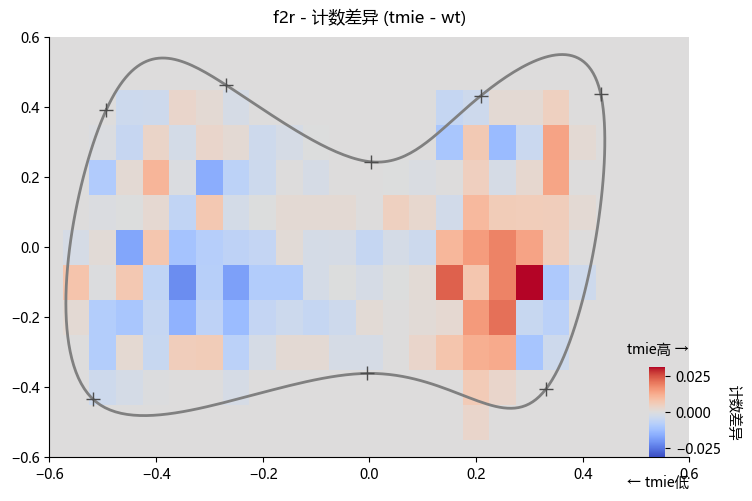

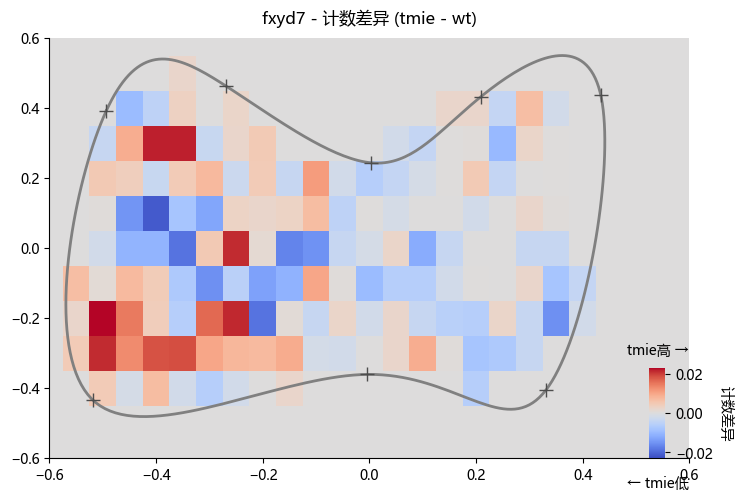

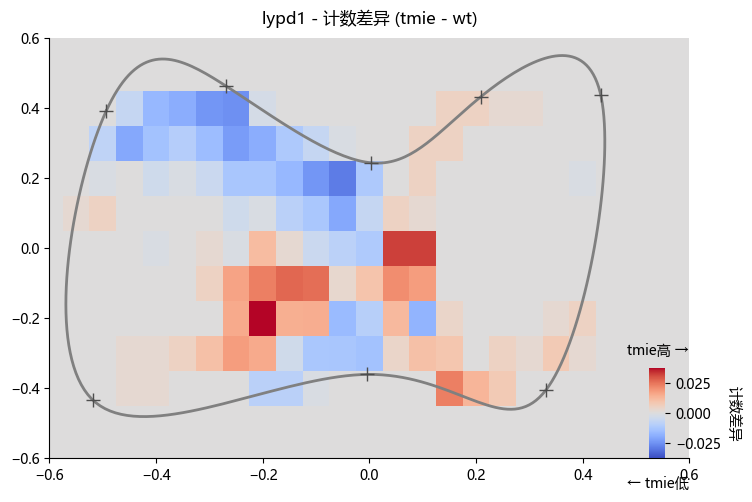

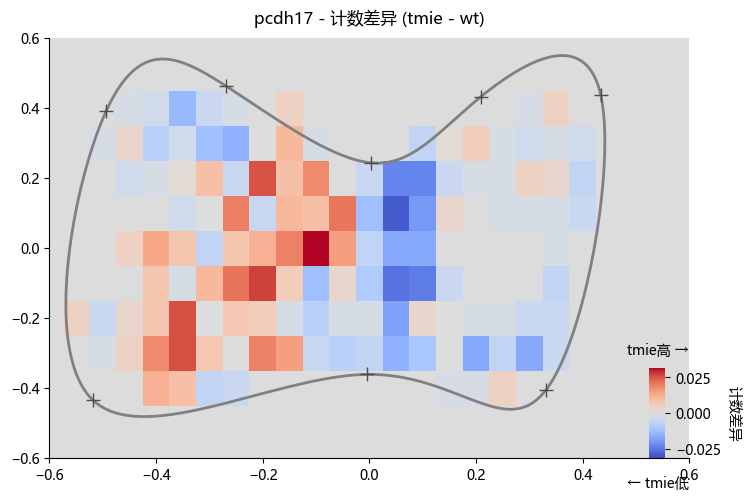

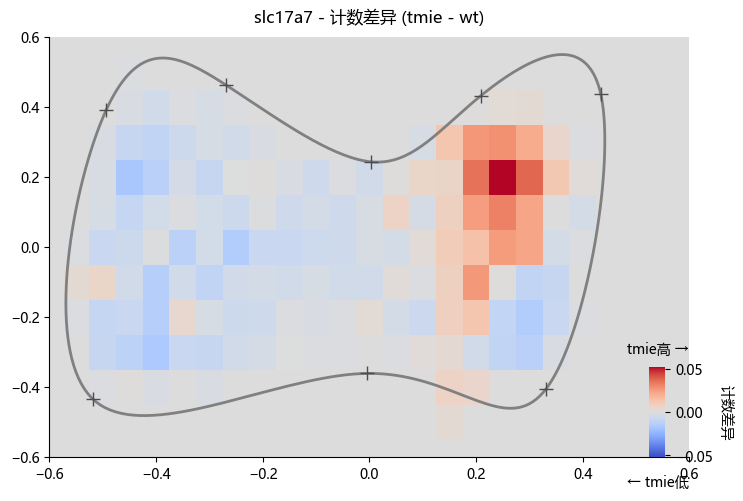

In [7]:
# ----------------------
# 执行分析
# ----------------------
# ----------------------
# 保存结果和绘图
# ----------------------
min_count = 0
max_count = 0.02

# 创建结果文件夹
if cell_num > 0:
    comparison_results_folder = os.path.join(summary_folder, f"grid_comparison_{sample_types[0]}_vs_{sample_types[1]}_{cell_num}")
else:
    comparison_results_folder = os.path.join(summary_folder, f"grid_comparison_{sample_types[0]}_vs_{sample_types[1]}")
os.makedirs(comparison_results_folder, exist_ok=True)

print("\n===== 开始蒙特卡洛模拟比较 =====")
comparison_results = []
# 获取两个样品的数据

# 比较两个样品的所有共有标记
for marker in common_markers:
    gene = marker.replace('_isPositive', '')
    x_col = 'standardized_x'
    y_col = 'standardized_y'
    
    # 检查两个样品是否都有该标记和坐标列
    valid = True
    for st in sample_types:
        if x_col not in data1.columns or y_col not in data2.columns:
            print(f"⚠️ 警告: {st}未找到标准化坐标列，跳过 {marker}")
            valid = False
            break
        if marker not in common_markers:
            print(f"⚠️ 警告: {st}未找到标记 {marker}，跳过")
            valid = False
            break
    
    if not valid:
        continue
    
    print(f"\n===== 比较 {marker} 在 {sample_types[0]} 和 {sample_types[1]} 之间 =====")
        
    # 执行两个样品间的蒙特卡洛模拟
    result = monte_carlo_simulation(
        data1, data2, marker,
        x_col, y_col, bx_bins, by_bins, n_simulations
    )
    
    if result is not None:
        total_diff = np.sum(np.abs(result['real_diff']))
        print(f"{marker} 真实差异总和: {total_diff}")
        
        if total_diff > 0:
            # 进行p值校正
            result['corrected_p'] = correct_grid_pvalues(result['p_values'], method=correction_method)
            comparison_results.append(result)
            print(f"✅ {marker} 比较完成")
        else:
            print(f"❌ {marker} 真实差异总和为0，不添加到结果中")
    else:
        print(f"❌ {marker} 比较失败，未生成结果")



# ----------------------
# 修改绘图调用逻辑：只绘制差值热图和p值热图
# ----------------------
if comparison_results:
    print("\n===== 保存样品间比较结果并绘制差值热图 =====")
    for result in comparison_results:
        gene = result['gene']
        # 1. 保存原始数据文件
        np.savetxt(os.path.join(comparison_results_folder, f'{gene}_{sample_types[0]}_counts.csv'), 
                  result['real_counts1'], delimiter=',', fmt='%d')
        np.savetxt(os.path.join(comparison_results_folder, f'{gene}_{sample_types[1]}_counts.csv'), 
                  result['real_counts2'], delimiter=',', fmt='%d')
        np.savetxt(os.path.join(comparison_results_folder, f'{gene}_diff_counts.csv'), 
                  result['real_diff'], delimiter=',', fmt='%d')
        np.savetxt(os.path.join(comparison_results_folder, f'{gene}_corrected_p.csv'), 
                  result['corrected_p'], delimiter=',', fmt='%.6f')
        
        # 2. 数据校验
        sample1_data = data1
        sample2_data = data2
        required_cols = [f'{gene}_isPositive', 'standardized_x', 'standardized_y']
        s1_valid = all(col in sample1_data.columns for col in required_cols)
        s2_valid = all(col in sample2_data.columns for col in required_cols)
        
        if not s1_valid or not s2_valid:
            missing = []
            if not s1_valid:
                missing.append(f"{sample_types[0]}: {', '.join([c for c in required_cols if c not in sample1_data.columns])}")
            if not s2_valid:
                missing.append(f"{sample_types[1]}: {', '.join([c for c in required_cols if c not in sample2_data.columns])}")
            print(f"⚠️ {gene} 缺少列: {'; '.join(missing)}，跳过绘图")
            continue
        
        # 3. 只绘制计数差值热图和p值热图
        # 绘制计数差值热图（tmie高为红色，低为蓝色）
        plot_count_diff_heatmap(
            result=result,
            gene=gene,
            bx_min=bx_min,
            bx_max=bx_max,
            by_min=by_min,
            by_max=by_max,
            BX=BX,
            BY=BY,
            output_folder=comparison_results_folder
        )
        
        # 绘制样品间差异p值热图（保留）
        plot_sample_diff_p_heatmap(
            result=result,
            gene=gene,
            bx_min=bx_min,
            bx_max=bx_max,
            by_min=by_min,
            by_max=by_max,
            BX=BX,
            BY=BY,
            output_folder=comparison_results_folder
        )
else:
    print("\n⚠️ 没有生成任何有效比较结果")

print("\n===== 所有绘图完成 =====")

In [8]:
def xcol_two_sample_monte(data1, data2, is_positive_col, x_col, bx_bins, n_simulations):
    """
    按X轴列计算两个样品间的差异显著性
    逻辑：先分别用获取单个样品的列计数，再通过蒙特卡洛模拟比较差异
    """
    filtered1 = data1[data1[is_positive_col] != -1].copy()
    filtered1[is_positive_col] = filtered1[is_positive_col].astype(bool)
    filtered2 = data2[data2[is_positive_col] != -1].copy()
    filtered2[is_positive_col] = filtered2[is_positive_col].astype(bool)
    # 步骤1：分别计算两个样品的X轴列真实计数
    result1 = count_positive_in_x_bins(filtered1, is_positive_col, x_col, bx_bins)
    result2 = count_positive_in_x_bins(filtered2, is_positive_col, x_col, bx_bins)
    sum1 = np.sum(result1)
    sum2 = np.sum(result2)

    if result1 is None or result2 is None:
        print(f"⚠️ {is_positive_col}：单个样品x_bin计数分析失败，跳过两样品比较")
        return None
    
    # 提取两个样品的真实列计数
    real_counts1 = result1/sum1  # 样品1的X轴列计数比例（shape: (num_xbins,)）
    real_counts2 = result2/sum2  # 样品2的X轴列计数比例（shape: (num_xbins,)）
    
    # 计算两样品的真实差异（样品1 - 样品2，或根据需求改为tmie - wt）
    real_diff = real_counts1 - real_counts2
    total_real_diff = np.sum(np.abs(real_diff))
    
    if total_real_diff == 0:
        print(f"⚠️ {is_positive_col}：两样品真实差异总和为0，跳过模拟")
        return None
    
    # 步骤2：蒙特卡洛模拟比较两样品差异（打乱标记分配，计算差异显著性）
    # 合并两个样品的阳性标记值（用于打乱重分配）
    orig1 = filtered1[is_positive_col].values.copy()
    # orig2 = filtered2[is_positive_col].values.copy()

    sim_diffs = np.zeros((n_simulations, len(real_diff)))
    
    # 执行蒙特卡洛模拟（聚焦列差异）
    for i in tqdm(range(n_simulations), desc=f"模拟 {is_positive_col} 列差异"):
        # 打乱数据标签
        shuffled1 = orig1.copy()
        #shuffled2 = orig2.copy()
        np.random.shuffle(shuffled1)
        #np.random.shuffle(shuffled2)
        # 为临时数据赋值打乱后的标记，计算模拟列计数
        temp1 = filtered1.copy()
        temp1[is_positive_col] = shuffled1
        temp2 = filtered2.copy()
        #temp2[is_positive_col] = shuffled2
        
        # 调用计算单次模拟的列计数
        sim_result1 = count_positive_in_x_bins(temp1, is_positive_col, x_col, bx_bins)
        sim_result2 = count_positive_in_x_bins(temp2, is_positive_col, x_col, bx_bins)
        if sim_result1 is not None and sim_result2 is not None:
            sim_diff = sim_result1/sum1 - sim_result2/sum2
            sim_diffs[i] = sim_diff
    
    # 步骤3：计算差异p值（模拟差异绝对值 ≥ 真实差异绝对值的比例）
    p_matrix = np.abs(sim_diffs) >= np.abs(real_diff)
    p_values = (np.sum(p_matrix, axis=0)+1)/(n_simulations+1)
    
    # 返回两样品列差异分析结果
    return {
        'is_positive_col': is_positive_col,
        'gene': is_positive_col.replace('_isPositive', ''),
        'real_counts1': real_counts1,  # 样品1的X轴列计数比例
        'real_counts2': real_counts2,  # 样品2的X轴列计数比例
        'real_diff': real_diff,        # 两样品列差异（样品1 - 样品2）
        'sim_diffs': sim_diffs,        # 模拟差异数组
        'p_values': p_values,          # 未校正的差异p值
        'corrected_p': None            # 预留校正后p值字段
    }

In [9]:
# ----------------------
# 5. 批量执行所有标记的列差异分析（原代码保留，无修改）
# ----------------------
print("\n===== 开始按X轴列执行两样品差异显著性分析 =====")
xcol_diff_results = []  # 存储所有标记的列差异分析结果

for col in common_markers:
    gene = col.replace('_isPositive', '')
    x_col = 'standardized_x'  # X轴标准化坐标列（与主程序一致）
    
    # 检查坐标列是否存在
    if x_col not in data1.columns or x_col not in data2.columns:
        print(f"⚠️ 警告: {sample_types[0]}（wt）或{sample_types[1]}（tmie）未找到X轴坐标列 {x_col}，跳过 {col}")
        continue
    
    print(f"\n===== 分析标记: {col}（基因: {gene}） =====")
    print(f"使用X轴坐标列: {x_col}")
    print(f"X轴分箱数量: {num_xbins}")
    
    # 执行两样品列差异分析（原函数，假设已提前定义）
    result = xcol_two_sample_monte(
        data1=data1,
        data2=data2,
        is_positive_col=col,
        x_col=x_col,
        bx_bins=bx_bins,
        n_simulations=n_simulations
    )
    
    if result is not None:
        total_real = np.sum(np.abs(result['real_diff']))
        print(f"{col} 两样品列差异总和: {total_real}")
        
        if total_real > 0:
            # 执行p值校正（调用主程序中的correct_grid_pvalues，假设已定义）
            result['corrected_p'] = correct_grid_pvalues(result['p_values'], method=correction_method)
            # 新增：计算并存储wt(data1)和tmie(data2)的比例（用于后续绘图）
            sum1 = np.sum(result['real_counts1'])
            sum2 = np.sum(result['real_counts2'])
            result['tmie_proportion'] = result['real_counts1']
            result['wt_proportion'] = result['real_counts2']
            # 新增：计算比例差值（tmie - wt）
            result['proportion_diff'] = result['tmie_proportion'] - result['wt_proportion']
            xcol_diff_results.append(result)
            print(f"✅ {col} 按X轴列差异分析完成（已计算比例及差值）")
        else:
            print(f"❌ {col} 两样品列差异总和为0，不添加到结果中")
    else:
        print(f"❌ {col} 按X轴列差异分析失败，未生成结果")

print(f"\n===== 按X轴列差异分析结束：共{len(xcol_diff_results)}个标记分析成功 =====")


===== 开始按X轴列执行两样品差异显著性分析 =====

===== 分析标记: f2r_isPositive（基因: f2r） =====
使用X轴坐标列: standardized_x
X轴分箱数量: 20


模拟 f2r_isPositive 列差异: 100%|██████████| 10000/10000 [00:58<00:00, 169.82it/s]


f2r_isPositive 两样品列差异总和: 0.4908903592619731
✅ f2r_isPositive 按X轴列差异分析完成（已计算比例及差值）

===== 分析标记: fxyd7_isPositive（基因: fxyd7） =====
使用X轴坐标列: standardized_x
X轴分箱数量: 20


模拟 fxyd7_isPositive 列差异: 100%|██████████| 10000/10000 [01:06<00:00, 149.91it/s]


fxyd7_isPositive 两样品列差异总和: 0.3156662222845916
✅ fxyd7_isPositive 按X轴列差异分析完成（已计算比例及差值）

===== 分析标记: lypd1_isPositive（基因: lypd1） =====
使用X轴坐标列: standardized_x
X轴分箱数量: 20


模拟 lypd1_isPositive 列差异: 100%|██████████| 10000/10000 [01:04<00:00, 156.09it/s]


lypd1_isPositive 两样品列差异总和: 0.5579813320677107
✅ lypd1_isPositive 按X轴列差异分析完成（已计算比例及差值）

===== 分析标记: pcdh17_isPositive（基因: pcdh17） =====
使用X轴坐标列: standardized_x
X轴分箱数量: 20


模拟 pcdh17_isPositive 列差异: 100%|██████████| 10000/10000 [01:02<00:00, 159.05it/s]


pcdh17_isPositive 两样品列差异总和: 0.7140174481855411
✅ pcdh17_isPositive 按X轴列差异分析完成（已计算比例及差值）

===== 分析标记: slc17a7_isPositive（基因: slc17a7） =====
使用X轴坐标列: standardized_x
X轴分箱数量: 20


模拟 slc17a7_isPositive 列差异: 100%|██████████| 10000/10000 [01:07<00:00, 148.08it/s]

slc17a7_isPositive 两样品列差异总和: 0.7938475665748392
✅ slc17a7_isPositive 按X轴列差异分析完成（已计算比例及差值）

===== 按X轴列差异分析结束：共5个标记分析成功 =====


In [10]:
if xcol_diff_results:
    print("\n===== 保存按X轴列差异分析结果（含比例及差值） =====")
    # 定义路径（分离结果文件和可视化文件）
    results_folder = comparison_results_folder
    visualization_folder = os.path.join(comparison_results_folder, "grid_visualizations")
    os.makedirs(visualization_folder, exist_ok=True)
    
    for result in xcol_diff_results:
        gene = result['gene']
        
        # ---------------------- 原有文件保存（保留） ----------------------
        # 1. 真实计数（wt=data1，tmie=data2）
        np.savetxt(
            os.path.join(results_folder, f'{gene}_wt_xcol_counts.csv'),
            result['real_counts1'],
            delimiter=',',
            fmt='%.6f'
        )
        np.savetxt(
            os.path.join(results_folder, f'{gene}_tmie_xcol_counts.csv'),
            result['real_counts2'],
            delimiter=',',
            fmt='%.6f'
        )
        
        # 2. 计数比例（wt和tmie）
        np.savetxt(
            os.path.join(results_folder, f'{gene}_wt_xcol_proportions.csv'),
            result['wt_proportion'],
            delimiter=',',
            fmt='%.6f'
        )
        np.savetxt(
            os.path.join(results_folder, f'{gene}_tmie_xcol_proportions.csv'),
            result['tmie_proportion'],
            delimiter=',',
            fmt='%.6f'
        )
        
        # ---------------------- 新增：保存比例差值文件（tmie - wt） ----------------------
        np.savetxt(
            os.path.join(results_folder, f'{gene}_tmie_minus_wt_proportion_diff.csv'),
            result['proportion_diff'],
            delimiter=',',
            fmt='%.6f'
        )
        
        # 3. 原有差异与P值文件
        np.savetxt(
            os.path.join(results_folder, f'{gene}_xcol_real_diff.csv'),
            result['real_diff'],
            delimiter=',',
            fmt='%.6f'
        )
        np.savetxt(
            os.path.join(results_folder, f'{gene}_xcol_corrected_p.csv'),
            result['corrected_p'],
            delimiter=',',
            fmt='%.6f'
        )
                
        print(f"✅ {gene} 结果保存完成：")
        print(f"   - 比例差值文件: {gene}_tmie_minus_wt_proportion_diff.csv")
        print(f"   - 其他文件: 计数/比例/P值文件（按原格式保存）")
    # 1. 提取X轴分箱信息
    x_bin_edges = np.linspace(x_fine.min(), x_fine.max(), num_xbins+1)  # 直接使用原x轴分bin边界
    x_bin_labels = [f"Bin{i+1}\n[{x_bin_edges[i]:.2f}-{x_bin_edges[i+1]:.2f}]" for i in range(len(x_bin_edges)-1)]
    x_bin_num = len(x_bin_labels)  # x轴总bin数
    # 2. 整合所有基因的差值和P值数据
    marker_list = []          # 有效基因列表
    proportion_diff_all = []  # 比例差值（tmie - wt）：行=基因，列=bin
    corrected_p_all = []      # 校正P值
    # ---------- 1. 计算 20 个 bin 索引 ----------
    min_bin_idx  = np.digitize(x_fine.min(), bx_bins) - 1
    max_bin_idx  = np.digitize(x_fine.max(), bx_bins) - 1
    zero_bin_idx  = np.digitize(0, bx_bins) - 1
    x_bins_indices = np.arange(min_bin_idx, min_bin_idx + 20)   # 固定 20 个
    x_offsets = x_bins_indices - zero_bin_idx                 # 相对 0 的偏移量

    # ---------- 2. 以 5 为步长、以 0 为中心，只在现有 20 个偏移量里挑 ----------
    step = 5
    low  = int(np.floor(x_offsets.min() / step) * step)
    high = int(np.ceil(x_offsets.max() / step) * step)
    tick_labels = np.arange(low, high + 1, step)              # 5 的倍数
    tick_labels = tick_labels[np.isin(tick_labels, x_offsets)]  # 必存在

    # ---------- 3. 对应绘图位置 ----------
    tick_positions = [np.where(x_offsets == lab)[0][0] for lab in tick_labels]
    for result in xcol_diff_results:
        gene = result['gene']
        diff = result['proportion_diff']
        corr_p = result['corrected_p']
        
        diff = diff[min_bin_idx:max_bin_idx]
        corr_p = corr_p[min_bin_idx:max_bin_idx]
        
        marker_list.append(gene)
        proportion_diff_all.append(diff)
        corrected_p_all.append(corr_p)
    diff_df = pd.DataFrame(proportion_diff_all, index=marker_list, columns=[f"Bin{i+1}" for i in range(x_bin_num)])
    corr_p_df = pd.DataFrame(corrected_p_all, index=marker_list, columns=[f"Bin{i+1}" for i in range(x_bin_num)])
    diff_df.to_csv(os.path.join(results_folder, f'all_tmie_minus_wt_proportion_diff.csv'), index=True)
    corr_p_df.to_csv(os.path.join(results_folder, f'all_tmie_minus_wt_p_adj.csv'), index=True)


===== 保存按X轴列差异分析结果（含比例及差值） =====
✅ f2r 结果保存完成：
   - 比例差值文件: f2r_tmie_minus_wt_proportion_diff.csv
   - 其他文件: 计数/比例/P值文件（按原格式保存）
✅ fxyd7 结果保存完成：
   - 比例差值文件: fxyd7_tmie_minus_wt_proportion_diff.csv
   - 其他文件: 计数/比例/P值文件（按原格式保存）
✅ lypd1 结果保存完成：
   - 比例差值文件: lypd1_tmie_minus_wt_proportion_diff.csv
   - 其他文件: 计数/比例/P值文件（按原格式保存）
✅ pcdh17 结果保存完成：
   - 比例差值文件: pcdh17_tmie_minus_wt_proportion_diff.csv
   - 其他文件: 计数/比例/P值文件（按原格式保存）
✅ slc17a7 结果保存完成：
   - 比例差值文件: slc17a7_tmie_minus_wt_proportion_diff.csv
   - 其他文件: 计数/比例/P值文件（按原格式保存）


In [11]:
diff_df = pd.read_csv(os.path.join(results_folder, f'all_tmie_minus_wt_proportion_diff.csv'), index_col = 0, header = 0)
corr_p_df = pd.read_csv(os.path.join(results_folder, f'all_tmie_minus_wt_p_adj.csv'), index_col=0, header = 0)
# ----------------------
# 6. 保存分析结果（含比例差值文件）
# ----------------------
target_marker_order = ['lypd1', 'f2r', 'fxyd7', 'slc17a7', 'pcdh17']  # 从上到下的顺序
if xcol_diff_results:
    # ---------------------- 核心修改：绘制「比例差值+校正P值」双子图热图 ----------------------
    print("\n===== 绘制比例差值+校正P值整合热图 =====")
    # 绘图参数（可根据数据调整）
    diff_abs_max = 0.1  # 比例差值的最大绝对值（确保颜色对称，如±0.1）
    p_threshold = 0.05  # 显著性阈值
    
    # 1. 提取X轴分箱信息
    x_bin_edges = np.linspace(x_fine.min(), x_fine.max(), num_xbins+1)  # 直接使用原x轴分bin边界
    x_bin_labels = [f"Bin{i+1}\n[{x_bin_edges[i]:.2f}-{x_bin_edges[i+1]:.2f}]" for i in range(len(x_bin_edges)-1)]
    x_bin_num = len(x_bin_labels)  # x轴总bin数
    
    # 3. 无有效数据时跳过
    if len(marker_list) == 0:
        print("⚠️ 无有效基因数据，跳过热图绘制")
    else:
        # 4. 转换为DataFrame        
        # 1. 筛选：只保留目标Marker的数据（排除不在目标列表中的Marker）
        diff_df_filtered = diff_df.loc[diff_df.index.isin(target_marker_order)]  # 计数数据筛选
        corr_p_df_filtered = corr_p_df.loc[corr_p_df.index.isin(target_marker_order)]  # p值数据筛选
        
        # 2. 重排序：按target_marker_order的顺序调整行索引（核心步骤）
        diff_df = diff_df_filtered.reindex(target_marker_order)  # 计数数据按目标顺序排列
        corr_p_df = corr_p_df_filtered.reindex(target_marker_order)  # p值数据按目标顺序排列

        # 5. 数据预处理
        diff_clipped = diff_df.clip(lower=-diff_abs_max, upper=diff_abs_max)  # 限制差值范围，避免颜色溢出
        corr_p_clipped = corr_p_df.clip(upper=p_threshold)  # P值超过阈值设为阈值
        
        # 6. 创建双生子图（上：比例差值，下：校正P值）
        fig, (ax1, ax2) = plt.subplots(
            2, 1, 
            figsize=(12, 1*len(target_marker_order)),  # 高度随基因数量自适应
            gridspec_kw={'height_ratios': [1, 0.8]}  # 差值图略高，P值图略矮
        )
        fig.suptitle(
            f"X-axis Bins Analysis: wt vs tmie",
            fontsize=14,
            y=0.98
        )
        
        # ---------------------- 子图1：比例差值热图（核心修改） ----------------------
        # 颜色映射：RdBu_r（红→白→蓝，反转后蓝负红正，符合需求）
        im1 = ax1.imshow(
            diff_clipped.values,
            cmap='RdBu_r',        # 关键：红色=tmie高，蓝色=tmie低，白色=无差异
            aspect='auto',
            vmin=-diff_abs_max,   # 颜色对称：负向最大= -diff_abs_max
            vmax=diff_abs_max     # 正向最大= diff_abs_max
        )
        # 坐标轴设置
        ax1.set_xticks(tick_positions)
        ax1.set_xticklabels(tick_labels, fontsize=15)
        ax1.set_xlabel("offset from border", fontsize=10)

        ax1.set_yticks(range(len(target_marker_order)))
        ax1.set_yticklabels([word.capitalize() for word in diff_clipped.index], fontsize=15)
        ax1.set_ylabel("Genes", fontsize=12, labelpad=10)
        ax1.set_title(
            f"Proportion Difference (tmie - wt)\n(Blue: tmie < wt | Red: tmie > wt)",
            fontsize=15,
            pad=8
        )
        
        # 差值图颜色条（带正负标签）
        cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8, aspect=20)
        cbar1.outline.set_visible(False)
        cbar1.set_label("tmie - wt Proportion", fontsize=15, labelpad=8)
        cbar1.set_ticks([-diff_abs_max, 0, diff_abs_max])
        cbar1.set_ticklabels([f"-{diff_abs_max:.3f}", "0", f"+{diff_abs_max:.3f}"])
        
        # ---------------------- 子图2：校正P值热图（保留，辅助判断显著性） ----------------------
        im2 = ax2.imshow(
            corr_p_clipped.values,
            cmap='Reds_r',       # 红色=P值小（显著），白色=P值大（不显著）
            aspect='auto',
            vmin=0,
            vmax=p_threshold
        )
        # 坐标轴设置（隐藏Y轴标签，与上子图基因顺序一致）
        ax2.set_xticks(tick_positions)
        ax2.set_xticklabels(tick_labels, fontsize=15)
        ax2.set_xlabel("offset from border", fontsize=10)
        
        ax2.set_yticks(range(len(target_marker_order)))
        ax2.set_yticklabels([word.capitalize() for word in diff_clipped.index], fontsize=15)
        ax2.set_title(f"q-value (FDR ≤ {p_threshold})", fontsize=15, pad=8)
        
        # P值图颜色条
        cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8, aspect=20)
        cbar2.outline.set_visible(False)
        cbar2.set_label("FDR", fontsize=10, labelpad=8)
        cbar2.set_ticks([0, p_threshold/2, p_threshold])
        cbar2.set_ticklabels([f"{x:.3f}" for x in [0, p_threshold/2, p_threshold]])
        
        # 7. 调整布局，避免标签截断
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # 8. 保存热图（高分辨率）
        heatmap_path = os.path.join(visualization_folder, "wt_vs_tmie_proportion_diff_heatmap")
        plt.savefig(heatmap_path + ".png", dpi=1200, bbox_inches='tight')
        plt.savefig(heatmap_path + ".pdf", dpi=1200, bbox_inches='tight')
        plt.savefig(heatmap_path + ".eps", format = 'eps', dpi=1200, bbox_inches='tight')
        plt.close(fig)
        
        print(f"✅ 整合热图保存完成：{heatmap_path}")
        print(f"   - 上子图：比例差值（红色=tmie高，蓝色=tmie低）")
        print(f"   - 下子图：显著性P值（红色=显著，白色=不显著）")

else:
    print("\n⚠️ 没有生成有效按X轴列差异分析结果，跳过保存和绘图")

print(f"\n===== 所有按X轴列差异分析流程完成！结果路径：{comparison_results_folder} =====")


===== 绘制比例差值+校正P值整合热图 =====
✅ 整合热图保存完成：D:/Ruiqi/vg_space_mapping/wt/summary\grid_comparison_tmie_vs_wt\grid_visualizations\wt_vs_tmie_proportion_diff_heatmap
   - 上子图：比例差值（红色=tmie高，蓝色=tmie低）
   - 下子图：显著性P值（红色=显著，白色=不显著）

===== 所有按X轴列差异分析流程完成！结果路径：D:/Ruiqi/vg_space_mapping/wt/summary\grid_comparison_tmie_vs_wt =====


## 🎯 位置显著性分析完成！

所有分析步骤已完成，包括：
- ✅ 数据加载和预处理
- ✅ 位置分布区间创建
- ✅ 蒙特卡洛模拟分析
- ✅ 多重比较校正
- ✅ 结果保存和可视化

**生成的文件**:
- 位置显著性结果CSV文件
- 热图可视化图片

**如果遇到问题**:
1. 检查模块导入是否正确
2. 验证数据文件路径
3. 查看错误信息进行调试

**下一步**: 可以查看生成的结果文件和图片，或进行其他数据分析。